# Testing designer module

Basic data and imports.

In [896]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import torch
import dgym as dg
import pyarrow.parquet as pq

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make designer.

In [897]:
import numpy as np
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

In [926]:
%%time
designer.reset_cache()
analogs = designer.design(deck[0], 100, temperature = 0.6)
rdkit.Chem.Draw.MolsToGridImage([a.mol for a in analogs], molsPerRow=10)

NotImplementedError: A valid chemfp license key is required to use a query arena with more than 50,000 fingerprints.

CPU times: user 122 ms, sys: 17 µs, total: 122 ms
Wall time: 131 ms


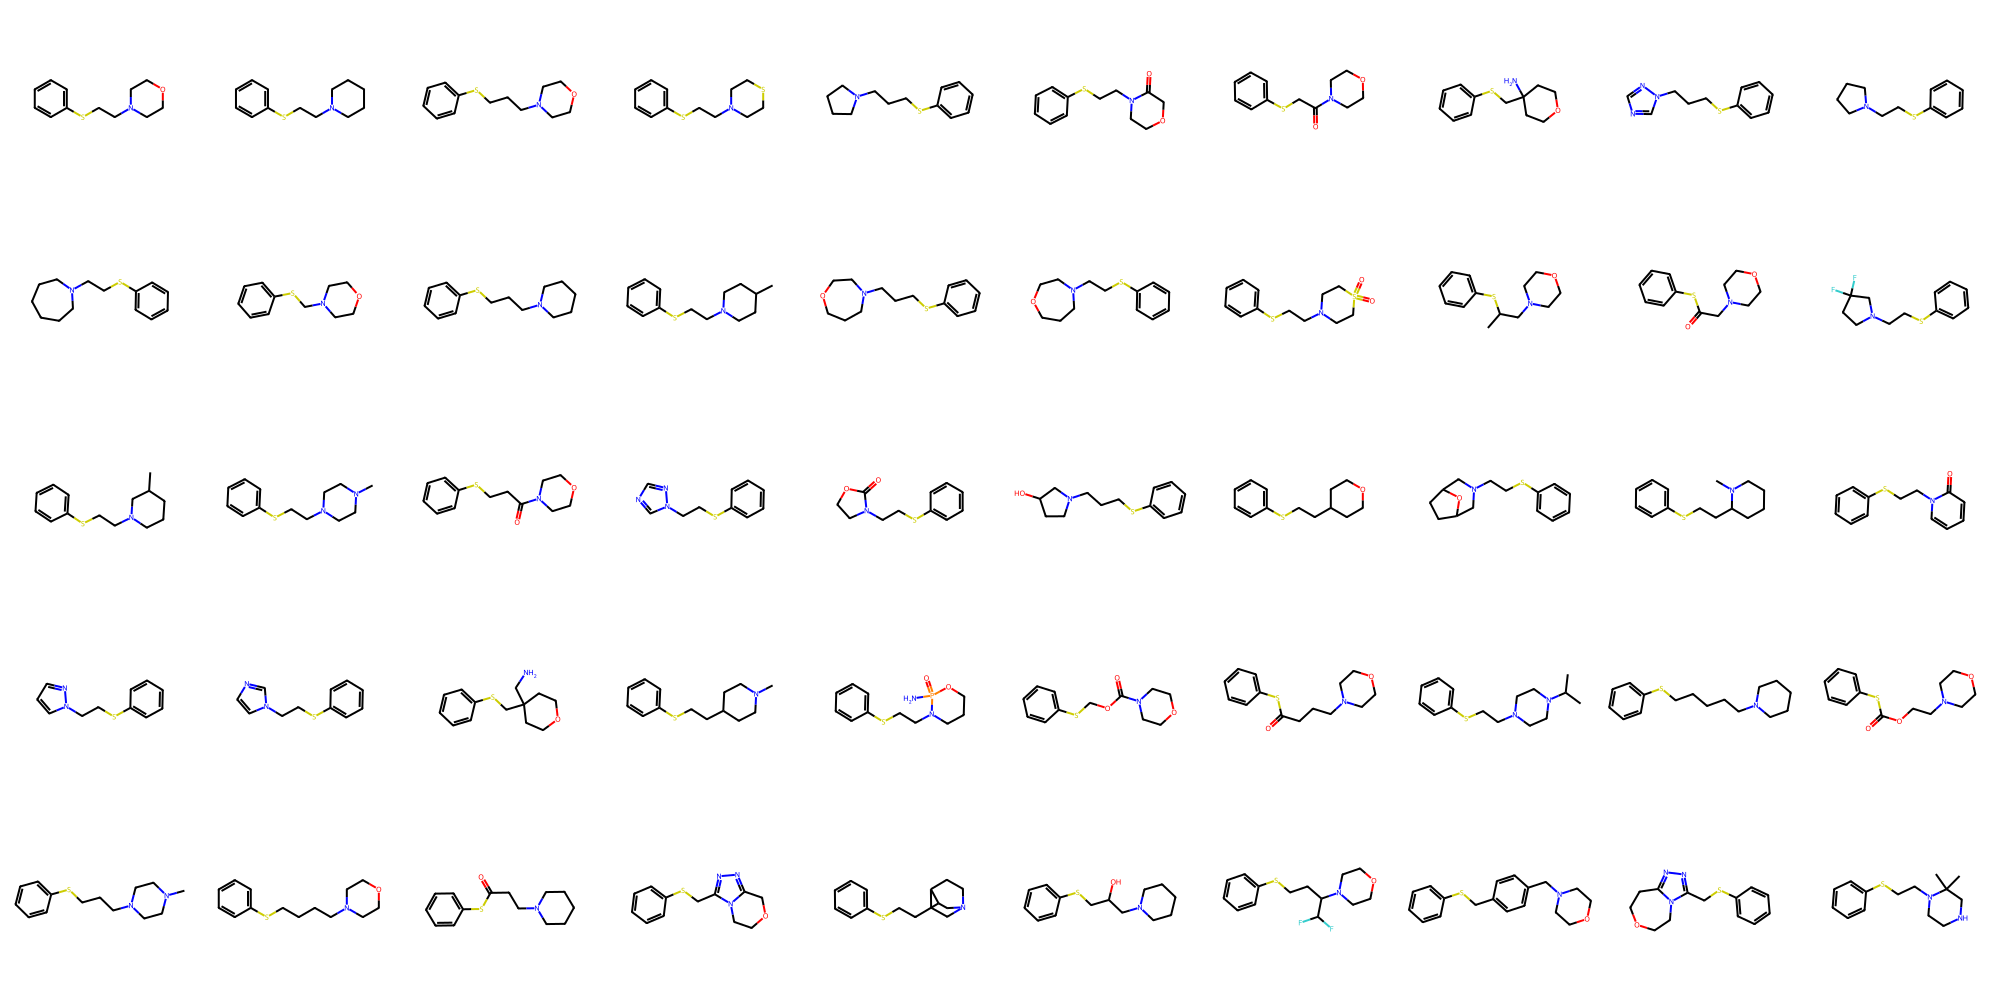

In [895]:
%%time
designer.reset_cache()
analogs = designer.design(deck[0], 100, temperature = 0.0)
rdkit.Chem.Draw.MolsToGridImage([a.mol for a in analogs], molsPerRow=10)